In [ ]:
values = [-79.98380825493032, -94.49225705217891, -108.71225528847204, -122.49468389687738, -135.6661581260147, -148.08772859908674, -159.63465671924394, -170.20091168484458, -179.6810804095997, -187.8571699761983, -194.57896254429858, -200.05105008630795, -204.61044684171537, -208.43918248078126, -211.57863908547824, -214.02210854567488, -215.78978432288233, -216.95542319267923, -217.61496501435153, -217.82132466719776, -217.58291072833003, -216.87628573849742, -215.65175933955106, -213.90603163798818, -211.69526937958221, -209.09212817432223, -206.17119826471804, -203.00508999212013, -199.69295533158152, -196.35074442551974, -193.06035537816337, -189.8308667494681, -186.55501047219394, -183.06069392183082, -179.2542117105031, -175.1991863726666, -171.0756731788178, -167.03982348246547, -163.11534963605288, -159.2287352228231, -155.2964956110315, -151.23118852939226, -146.93027417454329, -142.33852111546258, -137.53333289629666, -132.71309603139565, -128.0417590544564, -123.59860491258685, -119.44430740014644, -115.60103555259994, -112.01279980268534, -108.53108851258119, -104.92699301530357, -100.96792590633389, -96.51780339924133, -91.61016825933638, -86.45811136617436, -81.35159061418267, -76.55920266152545, -72.36363657378915, -69.13120246004124, -67.2265862696766, -66.89955810742106, -68.2943602627386, -71.52151625104463, -76.70470246344726, -83.83167044836364, -92.68055823513834, -102.95524909394577, -114.38812454999409, -126.72809759602461, -139.6218387806757, -152.59686865422714, -165.12655533166873, -176.63511337332272, -186.5447889155979, -194.41208013510413, -200.02879698531478, -203.38838135164485, -204.5366023742335, -203.50503488009923, -200.40626008941712, -195.50182186427367, -189.11370888724588, -181.5001257476972, -172.89158381453967, -163.53889451085274, -153.6454989063514, -143.29684942136493, -132.4885803025773, -121.35655129702292, -110.26515908732722, -99.54422342109518, -89.40394884116965, -80.07275858650486, -71.76045825545731, -64.5145663378725, -58.243266789565226, -52.82661613231532, -48.135167240373534]

In [ ]:
values = [v+abs(min(values)) for v in values]

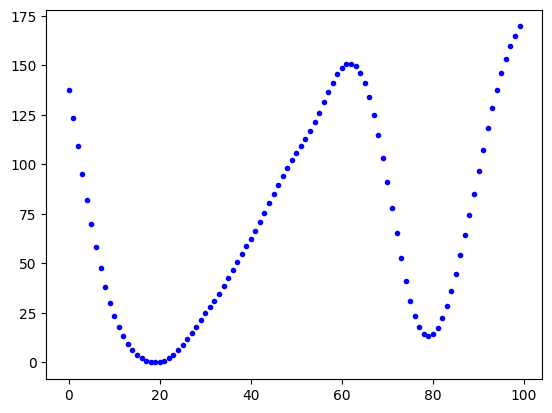

In [ ]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

# Генерация примера данных
# x = np.linspace(0, 100, 100)
# y = -np.sin(x/20) - 1
y = np.array(values)
x = np.array(range(len(y)))
plt.plot(x, y, 'b.', label='Исходные данные')


In [ ]:
import numpy as np
from scipy import optimize, signal
import matplotlib.pyplot as plt

# Модель для волны, состоящей из нескольких синусоид
def complex_wave(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 4):
        A, w, p, c = params[i:i+4]
        y += A * np.sin(w * x + p) + c
    return y

# Предварительная обработка данных -  удаление линейного тренда и нормализация
def preprocess_data(x, y):
    trend = np.polyfit(x, y, 1)
    detrended = signal.detrend(y)
    normalized = (detrended - np.mean(detrended)) / np.std(detrended)
    return normalized, trend

# Поиск пиков для оценки периода
# Тимур, теория горячего чая НЕ применима к дублированию функций!!!
def find_peaks(y, distance):
    return signal.find_peaks(y, distance=distance, prominence=55)[0]

# Экстраполяция сигнала с улучшениями
def extrapolate_signal(x, y, num_components=3, extrapolation_factor=0.2):
    y_processed, trend = preprocess_data(x, y)

    # Находим пики для оценки периода
    peaks = find_peaks(y_processed, distance=len(y)//10)
    if len(peaks) >= 2:
        estimated_period = np.mean(np.diff(peaks))
    else:
        estimated_period = len(y) // 2

    # Начальные параметры
    p0 = []
    amplitude_guess = np.std(y_processed)
    for i in range(num_components):
        p0.extend([amplitude_guess, 2*np.pi/estimated_period, 0, 0])

    # Подгонка модели
    popt, _ = optimize.complex_wave(complex_wave, x, y_processed, p0=p0, maxfev=100000)

    # Экстраполяция
    # еще сильнее ограничим длину
    extrapolation_length = int(len(x) * extrapolation_factor)
    x_extended = np.linspace(x.min() - extrapolation_length, x.max() + extrapolation_length, len(x) + 2 * extrapolation_length)
    y_extended = complex_wave(x_extended, *popt)

    # Восстановление масштаба
    y_extended = y_extended * np.std(y) + np.mean(y)

    # Добавление тренда обратно
    trend_poly = np.poly1d(trend)
    y_extended += trend_poly(x_extended)

    # Нужно выполнить оценку общего смещения и применить его
    shift = np.mean([y[i] - y_extended[i] for i in range(len(y))])

    # Применение смещения к экстраполированным данным
    y_extended_shifted = y_extended + shift

    return x_extended, y_extended_shifted, popt # Верну-ка я всё сразу ...


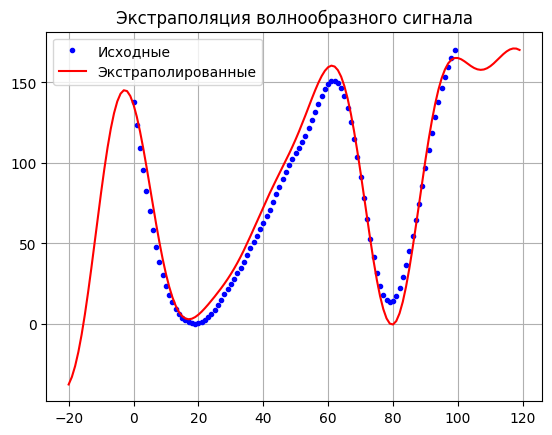

Компонент 1:
  Амплитуда: 0.62
  Частота: 0.0308
  Фаза: -4.26
  Смещение: 54.67
Компонент 2:
  Амплитуда: 0.22
  Частота: 0.0412
  Фаза: -9.74
  Смещение: 759.84
Компонент 3:
  Амплитуда: 1.25
  Частота: 0.0179
  Фаза: 1.82
  Смещение: -814.41


In [ ]:
# x = ...
# y = ...

# Вызов функции экстраполяции
x_extended, y_extended, popt = extrapolate_signal(x, y, 3)

# Визуализация
plt.plot(x, y, 'b.', label='Исходные')
plt.plot(x_extended, y_extended, 'r-', label='Экстраполированные')
plt.legend()
plt.title('Экстраполяция волнообразного сигнала')
plt.grid(True)
plt.show()

# Вывод параметров
# Это не я пишу!
for i in range(0, len(popt), 4):
    print(f"Компонент {i//4 + 1}:")
    print(f"  Амплитуда: {abs(popt[i]):.2f}")
    print(f"  Частота: {popt[i+1]/(2*np.pi):.4f}")
    print(f"  Фаза: {popt[i+2]:.2f}")
    print(f"  Смещение: {popt[i+3]:.2f}")